# HYSPLIT Modeling V2

This notebook represents the second version of the HYSPLIT modeling scripts. Currently in use are several functions within a related package called hypy.py. Please make sure to have this python file in the working directory of this notebook alongside a working installation of HYSPLIT and related NARR files.

New Implmentations:
1. Comparison of overlapping Fug/Stack Part/Gas same location and same concentration 
2. Efficeincy Testing

In [165]:
#Libraries Utilized: 
#USE Lab env!
%load_ext autoreload
%autoreload 2

#Basic py: 
import numpy as np
import pandas as pd
import datetime
import os
import datetime
import glob
import shutil

#Vis
import matplotlib.pyplot as plt

#Geo
import geopandas as gpd
import fiona
from shapely.geometry import Point
import descartes
import contextily as ctx #Basemaps 
import rtree

#Custom Functions:
from hypy import HYSPLIT_configure, RSEI_merger, hysplit_input_conversion, chem_date_comb,chem_date_comb_2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocess the TRI Data

In [272]:
#Load the Data
tri_df = pd.read_csv('TRI_Carc_FSRel_9099.csv').drop(columns =['sumer','Unnamed: 0'])

#First let's load in the features to seperate the particles and gasses
TRI_chem_info = pd.read_csv('TRI_Carc_Half_Lives.csv')

#Keep only those entries with complete information
TRI_chems = TRI_chem_info.dropna(subset = ['CAS'])
TRI_chems = TRI_chems.rename(columns = {'Unnamed: 8':'Phase'})

#Merge that data onto the tri dataframe
tri_df = pd.merge(tri_df,TRI_chem_info,left_on ='CAS#/COMPOUNDID',right_on = 'CAS',how='left')
tri_df = tri_df.drop(columns = ['CAS','Chems','88-ONE-TIMERELEASE'])

In [273]:
#Seperate into the known differential modeling variants:
fug_par_df = tri_df[(tri_df['51-FUGITIVEAIR']>0) & (tri_df['Particle']==1)]
fug_gas_df = tri_df[(tri_df['51-FUGITIVEAIR']>0) & (tri_df['Gas']==1) ]
stack_par_df = tri_df[(tri_df['52-STACKAIR']>0) & (tri_df['Particle']==1)]
stack_gas_df = tri_df[(tri_df['52-STACKAIR']>0) & (tri_df['Gas']==1) ]

print('Fugitive Particle Releases shape: ' + str(fug_par_df.shape))
print('Total number of unique chemicals: '+str(fug_par_df['CAS#/COMPOUNDID'].drop_duplicates().shape))
print('Total number of unique polluters: '+str(fug_par_df['FRSID'].drop_duplicates().shape))

print('\nFugitive Gas Releases shape: ' + str(fug_gas_df.shape))
print('Total number of unique chemicals: '+str(fug_gas_df['CAS#/COMPOUNDID'].drop_duplicates().shape))
print('Total number of unique polluters: '+str(fug_gas_df['FRSID'].drop_duplicates().shape))

print('\nStack Particle Releases shape: ' + str(stack_par_df.shape))
print('Total number of unique chemicals: '+str(stack_par_df['CAS#/COMPOUNDID'].drop_duplicates().shape))
print('Total number of unique polluters: '+str(stack_par_df['FRSID'].drop_duplicates().shape))

print('\nStack Gas Releases shape: ' + str(stack_gas_df.shape))
print('Total number of unique chemicals: '+str(stack_gas_df['CAS#/COMPOUNDID'].drop_duplicates().shape))
print('Total number of unique polluters: '+str(stack_gas_df['FRSID'].drop_duplicates().shape))

#Expect:
#Fugitive Particle Releases shape: (195, 30)
#Total number of unique chemicals: (9,)
#Total number of unique polluters: (40,)

#Fugitive Gas Releases shape: (526, 30)
#Total number of unique chemicals: (20,)
#Total number of unique polluters: (75,)

#Stack Particle Releases shape: (148, 30)
#Total number of unique chemicals: (6,)
#Total number of unique polluters: (27,)

#Stack Gas Releases shape: (483, 30)
#Total number of unique chemicals: (17,)
#Total number of unique polluters: (72,)

Fugitive Particle Releases shape: (195, 30)
Total number of unique chemicals: (9,)
Total number of unique polluters: (40,)

Fugitive Gas Releases shape: (526, 30)
Total number of unique chemicals: (20,)
Total number of unique polluters: (75,)

Stack Particle Releases shape: (148, 30)
Total number of unique chemicals: (6,)
Total number of unique polluters: (27,)

Stack Gas Releases shape: (483, 30)
Total number of unique chemicals: (17,)
Total number of unique polluters: (72,)


In [274]:
#Which entries have identical facilities and chemical releases? 
temp = fug_par_df.groupby(['FRSID','51-FUGITIVEAIR']).size()
tot_locs = fug_par_df
print('Percentage of fugitive particle releases which have identical releases and locations: {0:0.2f}%'.format(
    temp[temp>1].shape[0]/temp.shape[0] * 100))

temp = fug_gas_df.groupby(['FRSID','51-FUGITIVEAIR']).size()
tot_locs = fug_gas_df
print('Percentage of fugitive gas releases which have identical releases and locations: {0:0.2f}%'.format(
    temp[temp>1].shape[0]/temp.shape[0] * 100))

temp = stack_par_df.groupby(['FRSID','52-STACKAIR']).size()
tot_locs = stack_par_df
print('Percentage of stack particle releases which have identical releases and locations: {0:0.2f}%'.format(
    temp[temp>1].shape[0]/temp.shape[0] * 100))

temp = stack_gas_df.groupby(['FRSID','52-STACKAIR']).size()
tot_locs = stack_gas_df
print('Percentage of stack gas releases which have identical releases and locations: {0:0.2f}%'.format(
    temp[temp>1].shape[0]/temp.shape[0] * 100))

Percentage of fugitive particle releases which have identical releases and locations: 24.41%
Percentage of fugitive gas releases which have identical releases and locations: 16.33%
Percentage of stack particle releases which have identical releases and locations: 20.95%
Percentage of stack gas releases which have identical releases and locations: 13.92%


## Efficiency Exploration

In [275]:
#Average number of releases per location, rounded to nearest whole number: 
print('Average number of Fugitive Particle Releases: {0:1.0f}'.format(fug_par_df.groupby(['FRSID']).size().mean()))
print('Average number of Fugitive Gas Releases: {0:1.0f}'.format(fug_gas_df.groupby(['FRSID']).size().mean()))
print('Average number of Stack Particle Releases: {0:1.0f}'.format(stack_par_df.groupby(['FRSID']).size().mean()))
print('Average number of Stack Gas Releases: {0:1.0f}'.format(stack_gas_df.groupby(['FRSID']).size().mean()))

Average number of Fugitive Particle Releases: 5
Average number of Fugitive Gas Releases: 7
Average number of Stack Particle Releases: 5
Average number of Stack Gas Releases: 7


**Exploring Overlap with EPA Monitor Locations**

In [86]:
#Import the data:

#Appears there are monitors which did not record over the time period of interest. 
EPA_mon = pd.read_csv('.\\TRIChemicals_Monitors.csv')

#Collect only monitors which have a first year below 1990 and a last year above 1999
valid_monitors = EPA_mon[(EPA_mon['first_year']<1990) & (EPA_mon['last_year']>1999)]

#it appears there are no 1:1 matches for latitude or longitude --> let's find the closest 

In [162]:
#Calculating the euclidean distance to find the nearest sensor to the emission source
locs = tri_df.drop_duplicates(subset=['LATITUDE','LONGITUDE'])
a= []
for idx in range(valid_monitors.shape[0]):
    temp =valid_monitors.iloc[idx]
    locs['euc_dist']= np.linalg.norm((locs[['LATITUDE','LONGITUDE']].values - temp[['latitude','longitude']].values).astype('float64'),
               axis=1)
    a.append(locs[locs['euc_dist']==locs['euc_dist'].min()].iloc[0])

nearest = pd.concat([valid_monitors.reset_index(),pd.DataFrame(a).reset_index()],axis=1)
nearest = nearest.drop(columns=['geometry','index'])

C:\Users\u0890227\Anaconda3\envs\lab\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [228]:
#Plot the two points in each dataframe
EPA = gpd.GeoDataFrame(nearest,
                       geometry=gpd.points_from_xy(x=nearest.longitude, y=nearest.latitude))

EPA.crs = {'init' :'epsg:4326'}
EPA = EPA.to_crs({'init': 'epsg:3857'})

TRI = gpd.GeoDataFrame(nearest, geometry=gpd.points_from_xy(nearest.LONGITUDE, nearest.LATITUDE))
TRI.crs = {'init': 'epsg:4326'}
TRI = TRI.to_crs({'init': 'epsg:3857'})

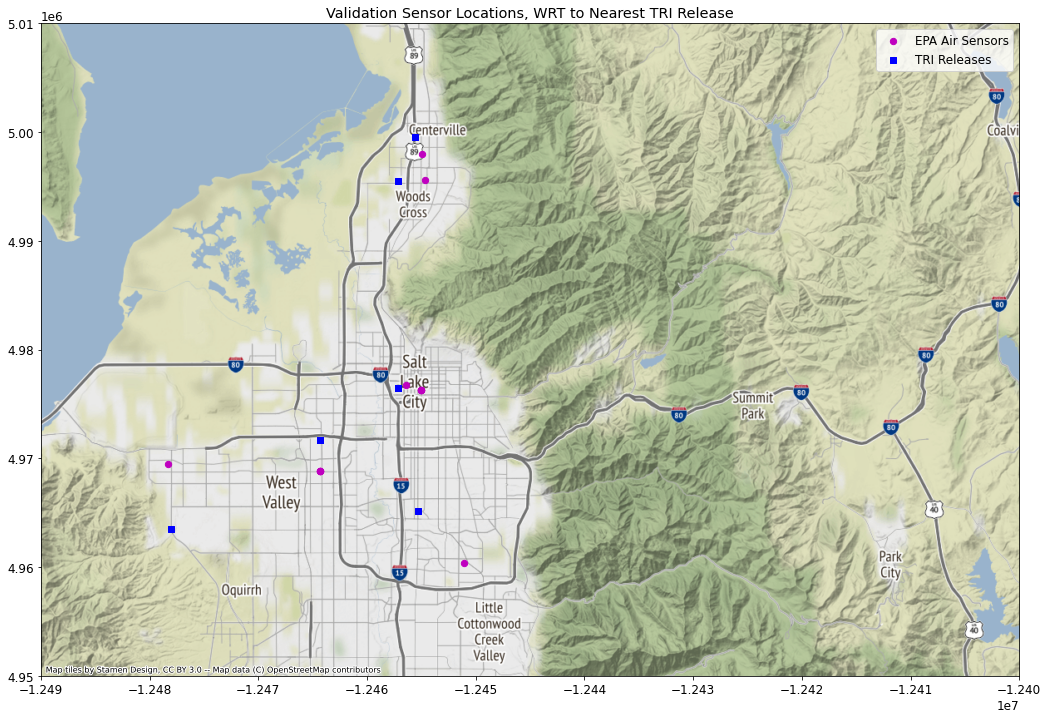

In [224]:
fig,ax = plt.subplots(figsize=(24,12))
plt.rcParams.update({'font.size': 12})
ax.set_xlim(-1.249e7, -1.24e7)
ax.set_ylim(4950000, 5010000)

EPA.plot(ax = ax,color = 'm',markersize = 40,marker='o')
TRI.plot(ax = ax,color = 'b',markersize = 40,marker='s')
ax.legend(['EPA Air Sensors','TRI Releases'])
ax.set_title('Validation Sensor Locations, WRT to Nearest TRI Release')
ctx.add_basemap(ax)

1. Note, the data point in the cetner of the plot where there is one TRI release for the two EPA air sensors is not a bug. It is the nearest release to both those sensors.
2. In total, there are 6 sensors with usable proximity levels. 
3. The maximum distance between these points is XX {TO DO}
    - Requires conversion to UTM for 12T then find distance in this unit preserving mapping
4. There are additional sensors which are in the southern portion of the state (x2) part are far from any TRI releases (nearest is over 100 miles).

## Date Mapping and Model Preperation

In [237]:
#Organize the data into daily releases
#fug_par_df = chem_date_comb_2(data = fug_par_df,
#                            freq = "3H",
#                            release_type = 'fugitive'
#                             )

print('\nProcessing Fugitive Gases')
fug_gas_df = chem_date_comb_2(data = fug_gas_df,
                            freq = "3H",
                            release_type = 'fugitive'
                             )

#stack_par_df = chem_date_comb_2(data = stack_par_df,
#                            freq = "3H",
#                            release_type = 'stack'
#                             )

print('\nProcessing Stack Gases')
stack_gas_df = chem_date_comb_2(data = stack_gas_df,
                            freq = "3H",
                            release_type = 'stack'
                             )


Processing Fugitive Gases
Percentage Complete: 0.00
Percentage Complete: 9.51
Percentage Complete: 19.01
Percentage Complete: 28.52
Percentage Complete: 38.02
Percentage Complete: 47.53
Percentage Complete: 57.03
Percentage Complete: 66.54
Percentage Complete: 76.05
Percentage Complete: 85.55
Percentage Complete: 95.06

Processing Stack Gases
Percentage Complete: 0.00
Percentage Complete: 10.35
Percentage Complete: 20.70
Percentage Complete: 31.06
Percentage Complete: 41.41
Percentage Complete: 51.76
Percentage Complete: 62.11
Percentage Complete: 72.46
Percentage Complete: 82.82
Percentage Complete: 93.17


In [238]:
#Double Check the fill
print('Fugitive Particle Releases shape: ' + str(fug_par_df.shape))
print('Fugitive Gas Releases shape: ' + str(fug_gas_df.shape))
print('Stack Particle Releases shape: ' + str(stack_par_df.shape))
print('Stack Gas Releases shape: ' + str(stack_gas_df.shape))

#Expect: 
#Fugitive Particle Releases shape: (569704, 34)
#Fugitive Gas Releases shape: (1536712, 34)
#Stack Particle Releases shape: (432400, 34)
#Stack Gas Releases shape: (1411088, 34)

Fugitive Particle Releases shape: (195, 30)
Fugitive Gas Releases shape: (1536712, 32)
Stack Particle Releases shape: (148, 30)
Stack Gas Releases shape: (1411088, 32)


In [239]:
#Need the Stack Heights as well. 
RSEI_fac_df = pd.read_csv("./RSEI_Facility_Data.csv")

C:\Users\u0890227\Anaconda3\envs\lab\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19,23,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [240]:
#We will add the stack information to the fugitive emissions, although we most likely won't use it
#fug_par_df = RSEI_merger(RSEI_fac_df,fug_par_df)
fug_gas_df = RSEI_merger(RSEI_fac_df,fug_gas_df)
#stack_par_df = RSEI_merger(RSEI_fac_df,stack_par_df)
stack_gas_df = RSEI_merger(RSEI_fac_df,stack_gas_df)

#Convert all inputs to usable metrics: 
#fug_par_prepped_df = hysplit_input_conversion(fug_par_df,0)
fug_gas_prepped_df = hysplit_input_conversion(fug_gas_df,0)
#stack_par_prepped_df = hysplit_input_conversion(stack_par_df,1)
stack_gas_prepped_df = hysplit_input_conversion(stack_gas_df,1)

### Filtering Data for Overlap 

In [10]:
fug_gas_prepped_df.head(3)

,date,CAS#/COMPOUNDID,Release,FRSID,CHEMICAL,MW,1/2 Life,Solubility in H2O,LATITUDE,LONGITUDE,...,FACILITYNAME,CITY,COUNTY,StackHeight,StackVelocity,StackDiameter,StackHeightSource,StackVelocitySource,StackDiameterSource,HS_loc_input
0,1990-01-01,50000,0.085616,110009506766,FORMALDEHYDE,30.026,1.5 minutes,Soluble,41.205150,-112.012620,...,LEVOLOR-KIRSCH WINDOW FASHIONS,OGDEN,WEBER,0.6,11.6,0.5,Fac Spec,Fac Spec,Fac Spec,41.21 -112.01 0.00
1,1990-01-01,127184,3.505137,110000469476,TETRACHLOROETHYLENE,165.800,100 days,Insoluble,40.713420,-111.899700,...,EDO CORP WESTERN DIV,SALT LAKE CITY,SALT LAKE,10.2,7.8,0.6,Fac Spec,Fac Spec,Fac Spec,40.71 -111.9 0.00
2,1990-01-01,7664939,0.085616,110012347193,"SULFURIC ACID (1994 AND AFTER ACID AEROSOLS"" O...",98.080,10-15 days,Soluble,41.744977,-111.849247,...,TTM TECHNOLOGIES INC,LOGAN,CACHE,10.0,8.6,0.5,Fac Spec,Fac Spec,Fac Spec,41.74 -111.85 0.00


In [11]:
#There are some duplicates in the naming process 
#TODO: Figure out a way to handle these
fug_gas_prepped_df[fug_gas_prepped_df.duplicated()][['FACILITYNAME','CAS#/COMPOUNDID','LATITUDE','LONGITUDE']].drop_duplicates()

,FACILITYNAME,CAS#/COMPOUNDID,LATITUDE,LONGITUDE
175234,THIOKOL PROPULSION CLEARFIELD OPERATIONS,123911,41.09394,-112.01698
175241,ATK LAUNCH SYSTEMS PROMONTORY,123911,41.66300,-112.43200


In [12]:
#Double check the naming scheme won't save over itself
#with this amount of information in the name, there will be no duplicates 
#except for the two facilities which have doubles coming in...but the overwrite should be ok for now. 

fug_gas_prepped_df[['date','FRSID','CAS#/COMPOUNDID','HS_loc_input']].drop_duplicates().shape

#Expect (1530872, 4)

(1530872, 4)

In [13]:
fug_gas_prepped_df[fug_gas_prepped_df['date']<= '01/01/1990 00:00:00'].shape

(60, 22)

# Speed Testing: 

Trying lots of hyperparameters on a small number of entries. Per each hyperparameter, a test was run on three different chemicals from three different locations. Time was calculated as the average between the three. Each run was on the same chemicals. 

In [42]:
#This will only output the samples for the first 6 hours 
samp = fug_gas_prepped_df[fug_gas_prepped_df['date']<= '01/01/1990 00:00:00']

#This clears any existing directories which begin with HO 
if len(glob.glob('C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_*'))!=0:
    for dirs in glob.glob('C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_*'):
        try:
            shutil.rmtree(dirs)
        except:
            print('unable to delete ' + dirs)

counter = 0 
import timeit
start_time = timeit.default_timer()

for rows in range(samp.shape[0]):
    counter +=1
    release = str(samp.iloc[rows]['Release'])
    fac = str(samp.iloc[rows]['FRSID'])
    chem = str(samp.iloc[rows]['CAS#/COMPOUNDID'])
    lat_lon_height = str(samp.iloc[rows]['HS_loc_input'])
    date = str(samp.iloc[rows]['date'])
    year = date[2:4]
    month = date[5:7]
    day = date[8:10]
    hour = date[11:13]
    date = year+' '+month + ' '+day+' '+hour
    save_name = "HO"+"_"+fac +"_"+ chem  +"_"+ lat_lon_height.replace(' ', '_') +"_"+year+'_'+month+'_'+day+'_'+hour
    print(save_name)
    print(release)
    print(lat_lon_height)
    HYSPLIT_configure(start_model = date, 
                    num_loc = '1', 
                    start_locs = lat_lon_height, 
                    tot_runtime = '48', 
                    mod_top = '10000.0',
                    input_data_grids = '2',
                    grid_1_dir = "C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\NARR_Weather_Data\\",
                    grid_1_name = 'NARR199001',
                    grid_2_dir = 'C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\NARR_Weather_Data\\',
                    grid_2_name = 'NARR199002',
                    chem_ident = chem,
                    emis_rate = release,
                    emis_hours = '3.0000',
                    samp_interval = '00 3 00',
                    puff_or_part = '0',
                    particle_num = '10000',
                    filename = save_name,
                    concplot_a = '1')
    
    if counter==3:
        break
        #print("Total Completed Runs: {0}".format(counter))
elapsed = timeit.default_timer() - start_time    

HO_110009506766_50000_41.21_-112.01_0.00_90_01_01_00
0.08561643835616438
41.21 -112.01 0.00
Script Completed
HO_110000469476_127184_40.71_-111.9_0.00_90_01_01_00
3.5051369863013697
40.71 -111.9 0.00
Script Completed
HO_110012347193_7664939_41.74_-111.85_0.00_90_01_01_00
0.08561643835616438
41.74 -111.85 0.00
Script Completed


In [43]:
print(elapsed)
print('Time of calculation: {0:1.2f} seconds\n'.format(elapsed/3))

73.52081959999987
Time of calculation: 24.51 seconds



##### This chart is built with the idea that comparison runs are made on Greg's Work PC

| ID | Time (seconds per run)| Particle Number | Run Type | Mod Top | Concplot a | Run Date | Image Name| Notes |
|------|------|------|------|------|------|------|------|------|
|1|5.40| 500|0|500|Concplot|May 27th 2020|Run_1.png|This causes an error for example 2 and 3 which both have a much lower concentration than example 1|
|2|6.71| 500|0|1000|Concplot|May27th 2020|Run_2.png|Same Error as above ^|
|3|15.99|500|0|2000|Concplot|May 27th 2020|Run_3.png|No errors|
|4|14.48|500|0|4000|Concplot|May 27th 2020|Run_4.png|Error with plot 3, no concentration data|
|5|8.74|500|0|100|Concplot|May 27th 2020|Run_5.png|Errors within all plots. Still trying to figure out what the top of the model is relative to the grid defined model layer|
|6|5.71|100|0|2000|Concplot|May 27th 2020|Run_6.png|Error on plot 2, hour 42|
|7|10.17|1000|0|2000|Concplot|May 27th 2020|Run_7.png|Error on plot 2, hour 42|
|8|19.38|500|0|10000|Concplot|June 1st 2020|Run_8.png|Run with standard setting for modtop (10,000). Recieved one error on plot 2 at time step 3. Can see the missing data in plotting legend|
|9|13.08|1000|0|10000|Concplot|June 1st 2020|Run_9.png|Run with standard setting for modtop (10,000). Recieved one error on 110009506766 for timestep hours after 6 indicating no concentration information was relayed. |
|10|17.50|2000|0|10000|Concplot|June 1st 2020|Run_10.png|Run with standard setting for modtop (10,000). No Errors. |
|11|26.04|4000|0|10000|Concplot|June 1st 2020|Run_11.png|Run with standard setting for modtop (10,000). No Errors. |
|12|97.32|100|1|10000|Concplot|June 1st 2020|Run_12.png|Run with standard setting for modtop (10,000). No Errors.|
|13|80.95|100|1|10000|Concplot|June 1st 2020|Run_13.png|Run with standard setting for modtop (10,000). Same as above.|
|14|49.55|100|3|10000|Concplot|June 1st 2020|Run_14.png|Run with standard setting for modtop (10,000). Changed to different puff config (3)|
|15|7.74|100|3|10000|Concplot|June 1st 2020|Run_15.png|Reducing the size of the grid to 0.5 x 0.5 degrees, mutliple errors. Graphs look very rough.|
|16|40.72|50|3|10000|Concplot|June 1st 2020|Run_16.png|Grid size back to 0.05, errors on 110012347193 on last run|
|17|34.57|20|3|10000|Concplot|June 1st 2020|Run_17.png|Shrinking number of puffs, hybrid approach|
|18|38.42|10|3|10000|Concplot|June 1st 2020|Run_18.png|Shrinking number of puffs, hybrid approach, multiple file errors|
|19|36.68|2|3|10000|Concplot|June 1st 2020|Run_19.png|Shrinking number of puffs, multiple files still showing error|
|20|13.78|2|4|10000|Concplot|June 1st 2020|Run_20.png|Trying different modeling type, no reported errors|
|21|12.28|2|4|10000|Concplot|June 1st 2020|Run_21.png|No visual difference|
|22|24.00|100|4|10000|Concplot|June 1st 2020|Run_22.png|Shrinking the plotting area, so as to only include Utah|
|23|6.66|20|4|10000|Concplot|June 1st 2020|Run_23.png|Retrying the smaller puff number with new boundary, no errors, visually identical to the previous entry|
|24|15.29|100|3|10000|Concplot|June 1st 2020|Run_24.png|definite visual differences. Showcases difference between gaussian (3) and top hat (4) with particle vertical distribution|
|25|11.96|100|2|10000|Concplot|June 1st 2020|Run_25.png|Changing the puff mode to explore the best parameters for speed. Puff number should not matter. Results do not look accurate|
|26|17.06|100|0|10000|Concplot|June 1st 2020|Run_26.png|Changing puff mode (1), still appears very general. Double 
|27|9.74|2500|0|10000|Concplot|June 1st 2020|Run_27.png|Changing back to particle mode, no model errors|
|28|6.74|1000|0|10000|Concplot|June 1st 2020|Run_28.png|Decreasing number of particles, errors. This appears to be too few particles|
|29|13.44|5000|0|10000|Concplot|June 1st 2020|Run_29.png|Increasing number of particles, error encountered in first plot: 110000469476 (higher conc)|
|30|24.51|5000|0|10000|Concplot|June 1st 2020|Run_30.png|Increasing number of particles, no errors encountered. This appears to be getting to be too many particles)|


Could the errors be coming from not having enough particles for the desired concentration?
- At 8, implementing Kevin Perry Recommendations
- At 12,trying puff simulations
- At 24, trying other puff simulation modes (top hat and vertical puff) and 3 (gaussian horizontal and top hat vertical)
- At 26, retry particle simulation using reduced dimension size. 

**CONCLUSION**
<br> Using this very rough first pass, it seems that two parameters strike as the best options. I plan to run these on longer simulations to see if they continue to perform well. 
1. Run 27 parameters (particle simulation)- increased accuracy
2. Run 22 parameters (top hat and particle vertical) - fastest speed

Other Conclusions:
- KP states the top of the model for concentration models is a reflective boundary. Thus, it must be high enough to not affect calculations. Going to set the parameter much higher, hopefully this will eliminate the errors. 
- For puff simulations, we need to alter several additional parameters including:
    1. Grid Cell Size: Kept at 0.05 
    2. Particles Released per cycle: Altered while watching the output. 


In [44]:
#Grab all the shapefiles and append to a list
#Create a directory for the run: 
path = ".\\speed_testing\\Run_30\\"
if os.path.isfile(path)==False:
    os.mkdir(path)

#plot the location
for idx,dirs in enumerate(sorted(glob.glob('C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_*'))):
    directory = dirs.replace('\\','\\\\') + '\\\\'
    print(directory)
    
    ls =[]
    for files in sorted(os.listdir(directory),reverse=False):
        data = gpd.read_file(directory+files)
        try:
            data = data.to_crs({'init': 'epsg:3857'})
            data['CONC'] = data['CONC'].astype(float)
            ls.append(data)
        except:
            print("error on file: " +files)

    #HYSPLIT Data 
    gdf = gpd.GeoDataFrame(pd.concat(ls,
                            ignore_index=True),crs=data.crs)
    gdf=gdf.sort_values('CONC')

    #Plot the figures
    fig,ax = plt.subplots(figsize=(24,12))
    plt.rcParams.update({'font.size': 12})

    #Plot the plume
    gdf.plot(cmap='YlOrRd',
             ax=ax,
             column='CONC',
             legend=True,
             alpha=0.8,
            legend_kwds={'label': "Pollutant Concentration log10(plbs/m^3)"})


    #Add some Parameters and labels
    ax.set_title("01.01.90 00:00:00 - {1} - 48 hr track -ID 30_{0}".format(str(idx+1),directory[46:58]))
    plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,# ticks along the top edge are off
        left=False,
        labelbottom=False,
        labelleft=False) # labels along the bottom edge are off

    #Add the background mappings
    ctx.add_basemap(ax)

    #SaveFig
    plt.savefig(path + 'Run_30_{0}.png'.format(str(idx+1)))
    plt.close()

C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_110000469476_127184_40.71_-111.9_0.00_90_01_01_00\\
C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_110009506766_50000_41.21_-112.01_0.00_90_01_01_00\\
C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_110012347193_7664939_41.74_-111.85_0.00_90_01_01_00\\


# Robustness Testing

From the last test, two hyperparameter sets stand out as being the fasest both averaging times of <7 seconds. Here we are going to make sure those calculations are robust by running both hyperparameters on a much larger subset of data (100 runs). 

In [ ]:
#Look at "more" vs "less" representative output data. 

#TODO

In [46]:
#This will only output the samples for the first 6 hours 
samp = fug_gas_prepped_df[fug_gas_prepped_df['date']<= '01/20/1990 00:00:00']

#This clears any existing directories which begin with HO 
if len(glob.glob('C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_*'))!=0:
    for dirs in glob.glob('C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_*'):
        try:
            shutil.rmtree(dirs)
        except:
            print('unable to delete ' + dirs)

counter = 0 
import timeit
start_time = timeit.default_timer()

for rows in range(samp.shape[0]):
    counter +=1
    release = str(samp.iloc[rows]['Release'])
    fac = str(samp.iloc[rows]['FRSID'])
    chem = str(samp.iloc[rows]['CAS#/COMPOUNDID'])
    lat_lon_height = str(samp.iloc[rows]['HS_loc_input'])
    date = str(samp.iloc[rows]['date'])
    year = date[2:4]
    month = date[5:7]
    day = date[8:10]
    hour = date[11:13]
    date = year+' '+month + ' '+day+' '+hour
    save_name = "HO"+"_"+fac +"_"+ chem  +"_"+ lat_lon_height.replace(' ', '_') +"_"+year+'_'+month+'_'+day+'_'+hour
    print(save_name)
    print(release)
    print(lat_lon_height)
    HYSPLIT_configure(start_model = date, 
                    num_loc = '1', 
                    start_locs = lat_lon_height, 
                    tot_runtime = '48', 
                    mod_top = '10000.0',
                    input_data_grids = '2',
                    grid_1_dir = "C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\NARR_Weather_Data\\",
                    grid_1_name = 'NARR199001',
                    grid_2_dir = 'C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\NARR_Weather_Data\\',
                    grid_2_name = 'NARR199002',
                    chem_ident = chem,
                    emis_rate = release,
                    emis_hours = '3.0000',
                    samp_interval = '00 3 00',
                    puff_or_part = '4',
                    particle_num = '20',
                    filename = save_name,
                    concplot_a = '1')
    
    if counter==100:
        break
        #print("Total Completed Runs: {0}".format(counter))
elapsed = timeit.default_timer() - start_time    

HO_110009506766_50000_41.21_-112.01_0.00_90_01_01_00
0.08561643835616438
41.21 -112.01 0.00
Script Completed
HO_110000469476_127184_40.71_-111.9_0.00_90_01_01_00
3.5051369863013697
40.71 -111.9 0.00
Script Completed
HO_110012347193_7664939_41.74_-111.85_0.00_90_01_01_00
0.08561643835616438
41.74 -111.85 0.00
Script Completed
HO_110002380254_123911_40.67_-112.09_0.00_90_01_01_00
0.07671232876712329
40.67 -112.09 0.00
Script Completed
HO_110000468985_91225_40.3_-111.73_0.00_90_01_01_00
0.024657534246575342
40.3 -111.73 0.00
Script Completed
HO_110069446790_123911_41.09_-112.02_0.00_90_01_01_00
3.287671232876712
41.09 -112.02 0.00
Script Completed
HO_110000469136_71432_40.89_-111.9_0.00_90_01_01_00
1.759931506849315
40.89 -111.9 0.00
Script Completed
HO_110009508504_7664939_40.73_-111.96_0.00_90_01_01_00
0.0017123287671232876
40.73 -111.96 0.00
Script Completed
HO_110000913218_98828_40.39_-110.12_0.00_90_01_01_00
0.03424657534246575
40.39 -110.12 0.00
Script Completed
HO_110055233251_7664

Script Completed
HO_110002136894_7664939_40.78_-111.95_0.00_90_01_01_03
0.08561643835616438
40.78 -111.95 0.00
Script Completed
HO_110064119555_7664939_40.71_-111.89_0.00_90_01_01_03
0.08561643835616438
40.71 -111.89 0.00
Script Completed
HO_110002136634_100425_40.86_-111.91_0.00_90_01_01_03
2.5684931506849313
40.86 -111.91 0.00
Script Completed
HO_110000469243_106990_40.79_-111.9_0.00_90_01_01_03
0.06506849315068493
40.79 -111.9 0.00
Script Completed
HO_110000913218_100414_40.39_-110.12_0.00_90_01_01_03
0.07876712328767123
40.39 -110.12 0.00
Script Completed
HO_110002272549_108101_41.2_-111.98_0.00_90_01_01_03
1.2188356164383563
41.2 -111.98 0.00
Script Completed
HO_110000469243_100414_40.79_-111.9_0.00_90_01_01_03
1.4496575342465754
40.79 -111.9 0.00
Script Completed
HO_110000469467_7664939_40.73_-111.89_0.00_90_01_01_03
0.08561643835616438
40.73 -111.89 0.00
Script Completed
HO_110032607329_123911_41.66_-112.43_0.00_90_01_01_03
3.4246575342465753
41.66 -112.43 0.00
Script Completed


In [50]:
print('100-Examples Average time: {0:1.2f} seconds\n'.format(elapsed/100))

100-Examples Average time: 7.87 seconds



In [56]:
#Did all import correctly?
#Create a directory for the run: 
path = ".\\robust_testing\\puff_100\\"
if os.path.isfile(path)==False:
    os.mkdir(path)
    
#plot the location
for idx,dirs in enumerate(sorted(glob.glob('C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_*'))):
    directory = dirs.replace('\\','\\\\') + '\\\\'
    
    ls =[]
    for files in sorted(os.listdir(directory),reverse=False):
        data = gpd.read_file(directory+files)
        try:
            data = data.to_crs({'init': 'epsg:3857'})
            data['CONC'] = data['CONC'].astype(float)
            ls.append(data)
        except:
            print("error on file: " +directory + files)
    
    if idx%10==0:     
        #HYSPLIT Data 
        gdf = gpd.GeoDataFrame(pd.concat(ls,
                                ignore_index=True),crs=data.crs)
        gdf=gdf.sort_values('CONC')

        #Plot the figures
        fig,ax = plt.subplots(figsize=(24,12))
        plt.rcParams.update({'font.size': 12})

        #Plot the plume
        gdf.plot(cmap='YlOrRd',
                 ax=ax,
                 column='CONC',
                 legend=True,
                 alpha=0.8,
                legend_kwds={'label': "Pollutant Concentration log10(plbs/m^3)"})


        #Add some Parameters and labels
        ax.set_title("01.01.90 00:00:00 - {1} - 48 hr track -ID 30_{0}".format(str(idx+1),directory[46:58]))
        plt.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,# ticks along the top edge are off
            left=False,
            labelbottom=False,
            labelleft=False) # labels along the bottom edge are off

        #Add the background mappings
        ctx.add_basemap(ax)

        #SaveFig
        plt.savefig(path + 'Run_{0}.png'.format(str(idx+1)))
        plt.close()

error on file: C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_110000468921_71432_40.84_-111.92_0.00_90_01_01_00\\hour_after_start_30
error on file: C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_110000468921_71432_40.84_-111.92_0.00_90_01_01_00\\hour_after_start_9
error on file: C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_110000469243_100414_40.79_-111.9_0.00_90_01_01_00\\hour_after_start_21
error on file: C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_110000469243_7664939_40.79_-111.9_0.00_90_01_01_00\\hour_after_start_21
error on file: C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_110000469270_100425_40.74_-111.96_0.00_90_01_01_00\\hour_after_start_12
error on file: C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_110000469476_127184_40.71_-111.9_0.00_90_01_01_00\\hour_after_start_24
error on file: C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_110000469485_100414_40.82_-111.92_0.00_90_01_01_03\\hour_after_start_9
error on file: C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_110000499069_1

### Particle Method 2500 

In [58]:
#This will only output the samples for the first 6 hours 
samp = fug_gas_prepped_df[fug_gas_prepped_df['date']<= '01/20/1990 00:00:00']

#This clears any existing directories which begin with HO 
if len(glob.glob('C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_*'))!=0:
    for dirs in glob.glob('C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_*'):
        try:
            shutil.rmtree(dirs)
        except:
            print('unable to delete ' + dirs)

counter = 0 
import timeit
start_time = timeit.default_timer()

for rows in range(samp.shape[0]):
    counter +=1
    release = str(samp.iloc[rows]['Release'])
    fac = str(samp.iloc[rows]['FRSID'])
    chem = str(samp.iloc[rows]['CAS#/COMPOUNDID'])
    lat_lon_height = str(samp.iloc[rows]['HS_loc_input'])
    date = str(samp.iloc[rows]['date'])
    year = date[2:4]
    month = date[5:7]
    day = date[8:10]
    hour = date[11:13]
    date = year+' '+month + ' '+day+' '+hour
    save_name = "HO"+"_"+fac +"_"+ chem  +"_"+ lat_lon_height.replace(' ', '_') +"_"+year+'_'+month+'_'+day+'_'+hour
    print(save_name)
    print(release)
    print(lat_lon_height)
    HYSPLIT_configure(start_model = date, 
                    num_loc = '1', 
                    start_locs = lat_lon_height, 
                    tot_runtime = '48', 
                    mod_top = '10000.0',
                    input_data_grids = '2',
                    grid_1_dir = "C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\NARR_Weather_Data\\",
                    grid_1_name = 'NARR199001',
                    grid_2_dir = 'C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\NARR_Weather_Data\\',
                    grid_2_name = 'NARR199002',
                    chem_ident = chem,
                    emis_rate = release,
                    emis_hours = '3.0000',
                    samp_interval = '00 3 00',
                    puff_or_part = '0',
                    particle_num = '2500',
                    filename = save_name,
                    concplot_a = '1')
    
    if counter==100:
        break
        #print("Total Completed Runs: {0}".format(counter))
elapsed = timeit.default_timer() - start_time    

HO_110009506766_50000_41.21_-112.01_0.00_90_01_01_00
0.08561643835616438
41.21 -112.01 0.00
Script Completed
HO_110000469476_127184_40.71_-111.9_0.00_90_01_01_00
3.5051369863013697
40.71 -111.9 0.00
Script Completed
HO_110012347193_7664939_41.74_-111.85_0.00_90_01_01_00
0.08561643835616438
41.74 -111.85 0.00
Script Completed
HO_110002380254_123911_40.67_-112.09_0.00_90_01_01_00
0.07671232876712329
40.67 -112.09 0.00
Script Completed
HO_110000468985_91225_40.3_-111.73_0.00_90_01_01_00
0.024657534246575342
40.3 -111.73 0.00
Script Completed
HO_110069446790_123911_41.09_-112.02_0.00_90_01_01_00
3.287671232876712
41.09 -112.02 0.00
Script Completed
HO_110000469136_71432_40.89_-111.9_0.00_90_01_01_00
1.759931506849315
40.89 -111.9 0.00
Script Completed
HO_110009508504_7664939_40.73_-111.96_0.00_90_01_01_00
0.0017123287671232876
40.73 -111.96 0.00
Script Completed
HO_110000913218_98828_40.39_-110.12_0.00_90_01_01_00
0.03424657534246575
40.39 -110.12 0.00
Script Completed
HO_110055233251_7664

Script Completed
HO_110002136894_7664939_40.78_-111.95_0.00_90_01_01_03
0.08561643835616438
40.78 -111.95 0.00
Script Completed
HO_110064119555_7664939_40.71_-111.89_0.00_90_01_01_03
0.08561643835616438
40.71 -111.89 0.00
Script Completed
HO_110002136634_100425_40.86_-111.91_0.00_90_01_01_03
2.5684931506849313
40.86 -111.91 0.00
Script Completed
HO_110000469243_106990_40.79_-111.9_0.00_90_01_01_03
0.06506849315068493
40.79 -111.9 0.00
Script Completed
HO_110000913218_100414_40.39_-110.12_0.00_90_01_01_03
0.07876712328767123
40.39 -110.12 0.00
Script Completed
HO_110002272549_108101_41.2_-111.98_0.00_90_01_01_03
1.2188356164383563
41.2 -111.98 0.00
Script Completed
HO_110000469243_100414_40.79_-111.9_0.00_90_01_01_03
1.4496575342465754
40.79 -111.9 0.00
Script Completed
HO_110000469467_7664939_40.73_-111.89_0.00_90_01_01_03
0.08561643835616438
40.73 -111.89 0.00
Script Completed
HO_110032607329_123911_41.66_-112.43_0.00_90_01_01_03
3.4246575342465753
41.66 -112.43 0.00
Script Completed


In [64]:
print('100-Examples Average time: {0:1.2f} seconds\n'.format(elapsed/100))

100-Examples Average time: 13.88 seconds



In [69]:
#Did all import correctly?
#Create a directory for the run: 
path = ".\\robust_testing\\part_2500\\"
if os.path.isfile(path)==False:
    os.mkdir(path)
    
count = 0    
#plot the location
for idx,dirs in enumerate(sorted(glob.glob('C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_*'))):
    directory = dirs.replace('\\','\\\\') + '\\\\'
    
    ls =[]
    for files in sorted(os.listdir(directory),reverse=False):
        data = gpd.read_file(directory+files)
        try:
            data = data.to_crs({'init': 'epsg:3857'})
            data['CONC'] = data['CONC'].astype(float)
            ls.append(data)
        except:
            count +=1
            print("error on file: " +directory + files)
    
    if idx%10==0:     
        #HYSPLIT Data 
        gdf = gpd.GeoDataFrame(pd.concat(ls,
                                ignore_index=True),crs=data.crs)
        gdf=gdf.sort_values('CONC')

        #Plot the figures
        fig,ax = plt.subplots(figsize=(24,12))
        plt.rcParams.update({'font.size': 12})

        #Plot the plume
        gdf.plot(cmap='YlOrRd',
                 ax=ax,
                 column='CONC',
                 legend=True,
                 alpha=0.8,
                legend_kwds={'label': "Pollutant Concentration log10(plbs/m^3)"})


        #Add some Parameters and labels
        ax.set_title("01.01.90 00:00:00 - {1} - 48 hr track -ID 30_{0}".format(str(idx+1),directory[46:58]))
        plt.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,# ticks along the top edge are off
            left=False,
            labelbottom=False,
            labelleft=False) # labels along the bottom edge are off

        #Add the background mappings
        ctx.add_basemap(ax)

        #SaveFig
        plt.savefig(path + 'Run_{0}.png'.format(str(idx+1)))
        plt.close()

error on file: C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_110000468985_91225_40.3_-111.73_0.00_90_01_01_03\\hour_after_start_45
error on file: C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_110000469136_71432_40.89_-111.9_0.00_90_01_01_00\\hour_after_start_33
error on file: C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_110000469136_71432_40.89_-111.9_0.00_90_01_01_00\\hour_after_start_6
error on file: C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_110000469181_7664939_40.59_-111.97_0.00_90_01_01_00\\hour_after_start_6
error on file: C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_110000469243_100414_40.79_-111.9_0.00_90_01_01_03\\hour_after_start_6
error on file: C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_110000469467_7664939_40.73_-111.89_0.00_90_01_01_03\\hour_after_start_42
error on file: C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_110000469476_127184_40.71_-111.9_0.00_90_01_01_03\\hour_after_start_39
error on file: C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_110000469485_1004

### Results

| Method | Time (seconds per run)| Errors | Notes |
|------|------|------|------|
| Particles (2500) | 13.88 | Yes - 25 in total | As expected the particle simulation is much more precise than the puff. On average it takes almost double the time though! |
| Puff (100) | 7.87 | Yes - 27 in total | see above | 

### Next Steps
1. See if it's possible to parallel the code//see how much faster it is on linux.
2. Figure out what this bug is that is causing some of the windows to not have data available
3. Figure out a way to bring all the data on to the server. 

In [ ]:
data = gpd.read_file('C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_110009506766_50000_41.21_-112.01_0.00_90_01_01_00\\hour_after_start_6\\')
gdf = gpd.GeoDataFrame(data,crs=data.crs)
gdf

In [ ]:
#Grab all the shapefiles and append to a list
ls =[]

#plot the location
for dirs in glob.glob('C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_*')
directory= 'C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\110009506766_50000_41.21_-112.01_0.00_90_01_01_00\\'
for files in sorted(os.listdir(directory),reverse=False):
    data = gpd.read_file(directory+files)
    data = data.to_crs({'init': 'epsg:3857'})
    data['CONC'] = data['CONC'].astype(float)
    ls.append(data)
    
#HYSPLIT Data 
gdf = gpd.GeoDataFrame(pd.concat(ls,
                        ignore_index=True),crs=data.crs)
gdf=gdf.sort_values('CONC')

#Plot the figures
fig,ax = plt.subplots(figsize=(24,12))
plt.rcParams.update({'font.size': 12})

#Plot the plume
gdf.plot(cmap='YlOrRd',
         ax=ax,
         column='CONC',
         legend=True,
         alpha=0.8,
        legend_kwds={'label': "Pollutant Concentration log10(plbs/m^3)"})


#Add some Parameters and labels
ax.set_title("01.01.90 00:00:00 - 11000950676 - 48 hr track -ID 1")
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,# ticks along the top edge are off
    left=False,
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off

#Add the background mappings
ctx.add_basemap(ax)

#SaveFig
plt.savefig('Run_1_1.png')

# Heidi Figures

#### New Figures: 06.03.20

In [ ]:
#Heidi Figures
#Source Data Prep
#source = pd.DataFrame([[40.297058,-111.734076]])
#source = gpd.GeoDataFrame(
#    df, geometry=gpd.points_from_xy(df[1], df[0]))
#source.crs = {'init': 'epsg:4326'}
#source = source.to_crs({'init': 'epsg:3857'})

In [ ]:
#Plot the figures
fig,ax = plt.subplots(figsize=(24,12))

#Plot the plume
gdf.plot(cmap='YlOrRd',
         ax=ax,
         column='CONC',
         legend=True,
         alpha=0.8,
        legend_kwds={'label': "Pollutant Concentration (plbs/m^3)"})

#Plot the origin source as a triangle
#source.plot(ax=ax,color = 'k',markersize = 80,marker='v')

#Add some Parameters and labels
plt.rcParams.update({'font.size': 18})
ax.set_title("48 Hr Tracking of Quinolene Emission Released on 01.01.90")
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,# ticks along the top edge are off
    left=False,
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off
ax.legend(['Quinolene Emitter'],loc='lower right',fontsize='small')

#Add the background mappings
ctx.add_basemap(ax)

#Save as a .png
#plt.savefig('Quinoline_Tracking.png')


In [ ]:
fig,ax = plt.subplots(figsize=(24,12))
#Create a boundning box to focus on where the emission is coming from
ax.set_xlim(-1.249e7, -1.235e7)
ax.set_ylim(4880000, 5000000)

#Plot the plume
gdf.plot(cmap='YlOrRd',
         ax=ax,
         column='CONC',
         legend=True,
         alpha=0.8,
        legend_kwds={'label': "Pollutant Concentration (plbs/m^3)"})

#Plot the origin source as a triangle
source.plot(ax=ax,color = 'k',markersize = 200,marker='v')

#Add some Parameters and labels
plt.rcParams.update({'font.size': 18})
ax.set_title("48 Hr Tracking of Quinolene Emission Released on 01.01.90")
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,# ticks along the top edge are off
    left=False,
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off
ax.legend(['Quinolene Emitter'],loc='lower right',fontsize='small')

#Add the background mappings
ctx.add_basemap(ax)

#Save as a .png
plt.savefig('Zoom_Quinoline_Tracking.png')


In [ ]:
#Plot the sensor locations
f,ax = plt.subplots(1,1,figsize=(24,12))

#plot the location
directory= 'C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\110000758378_108101_41.26_-112.23_0.00_90_01_01_00\\'
for files in os.listdir(directory):
    data = gpd.read_file(directory+files)
    data = data.to_crs({'init': 'epsg:3857'})
    data['CONC'] = data['CONC'].astype(float)
    data.plot(cmap='YlOrRd',ax=ax)

ax.set_title('HYSPLIT OUTPUT')
ctx.add_basemap(ax)

In [ ]:
#Plot the sensor locations
f,ax = plt.subplots(1,1,figsize=(24,12))

#plot the location
directory= 'C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\110000758378_108101_41.26_-112.23_0.00_90_01_01_06\\'
for files in os.listdir(directory):
    data = gpd.read_file(directory+files)
    data = data.to_crs({'init': 'epsg:3857'})
    #data['CONC'] = data['CONC'].astype(float)
    data.plot(cmap='YlOrRd',ax=ax)

ax.set_title('HYSPLIT OUTPUT')
ctx.add_basemap(ax)